In [9]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import os
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [44]:
LEARNING_RATE = 0.01
BATCH_SIZE = 4096
N_EPOCHS = 10
dataDirectory = 'dataSet'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device = ", device)

Device =  cuda


In [3]:
if not os.path.exists(dataDirectory):
    os.makedirs(dataDirectory)

downLoad = False
if not os.path.exists(os.path.join(dataDirectory, 'MNIST')):
    downLoad = True
trainData = datasets.MNIST(
    root = dataDirectory,
    train = True,
    transform = ToTensor(),
    download=downLoad
)
testData = datasets.MNIST(
    root = dataDirectory,
    train = False,
    transform = ToTensor(),
    download=downLoad
)

In [4]:
print("train data : ", trainData.data.shape)
print("test data : ", testData.data.shape)

train data :  torch.Size([60000, 28, 28])
test data :  torch.Size([10000, 28, 28])


In [5]:
loaders = {
    'trainLoader' : DataLoader(
        dataset=trainData, 
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=1
    )
    ,
    'testLoader' : DataLoader(
        dataset=testData, 
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=1
    )
}
loaders

{'trainLoader': <torch.utils.data.dataloader.DataLoader at 0x241d5361df0>,
 'testLoader': <torch.utils.data.dataloader.DataLoader at 0x24187e135b0>}

In [119]:
def train(
        model : nn.Module,
        optimizer : opt.Adam,
        lossFunction : nn.CrossEntropyLoss
):
        trainLoss = 0
        model.train()
        for idx, (data, target) in enumerate(loaders['trainLoader']):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = lossFunction(output, target)
            trainLoss += loss
            loss.backward()
            optimizer.step()


@torch.no_grad()
def test(
        model : nn.Module,
        lossFunction : nn.CrossEntropyLoss
):
    model.eval()
    testLoss = 0
    correct = 0
    for data, target in loaders['testLoader']:
        data, target = data.to(device), target.to(device)
        output = model(data)
        testLoss += lossFunction(output, target).item()
        pred = output.argmax(dim = 1, keepdim = True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    testLoss /= len(loaders['testLoader'].dataset)
    print("Accuracy : ", 100*correct / len(loaders['testLoader'].dataset))

In [124]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)


In [8]:
mlp = MLP().to(device=device)
optimizer = opt.Adam(mlp.parameters(), lr=LEARNING_RATE)
lossFunction = nn.CrossEntropyLoss()

In [13]:
for _ in tqdm.tqdm(range(N_EPOCHS)):
    train(
        model=mlp,
        optimizer=optimizer,
        lossFunction=lossFunction
    )
test(
    model=mlp,
    lossFunction=lossFunction
)   
    

100%|██████████| 10/10 [01:00<00:00,  6.07s/it]


Accuracy :  93.08


In [45]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6,kernel_size=5, padding=2)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))
        x = self.pool(F.sigmoid(self.conv2(x)))
        x = x.view(-1, 400)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

In [120]:
cnn = CNN().to(device=device)
optimizer2 = opt.Adam(cnn.parameters(), lr=LEARNING_RATE)
lossFunction2 = nn.CrossEntropyLoss()

In [123]:
for _ in tqdm.tqdm(range(N_EPOCHS)):
    train(
        model=cnn,
        optimizer=optimizer2,
        lossFunction=lossFunction2
    )
test(
    model=cnn,
    lossFunction=lossFunction2
)

100%|██████████| 10/10 [01:00<00:00,  6.00s/it]


Accuracy :  98.5


In [54]:
def shift_image(image, shiftBy = 2):
    image = image.numpy().squeeze()
    shifted_image = np.zeros_like(image)
    if shiftBy > 0:
        shifted_image[:, shiftBy:] = image[:, :-shiftBy]
    else:
        shifted_image[:, :shiftBy] = image[:, -shiftBy:]
    return torch.Tensor(shifted_image).unsqueeze(0)        

In [112]:
dataIterator = iter(loaders['testLoader'])
images, labels = dataIterator._next_data()

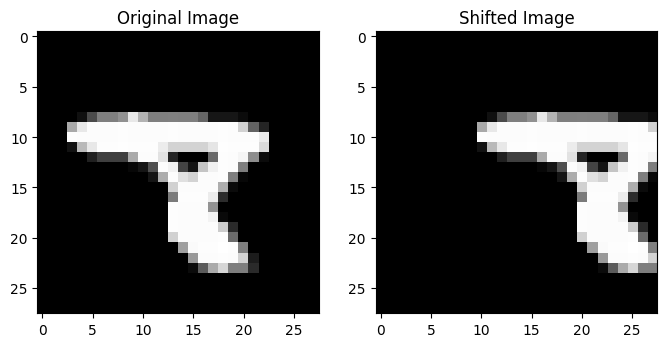

In [113]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(images[1].numpy().squeeze(), cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(shift_image(images[1], 7).squeeze(), cmap='gray')
plt.title('Shifted Image')
plt.show()

In [118]:
print("true label is : ", labels[1].item())

true label is :  8


In [114]:
cnnOutput = cnn(images[1].unsqueeze(0).to(device))
_, cnn_pred = torch.max(cnnOutput, 1)
print("Prediction of CNN : ", cnn_pred.item())

Prediction of CNN :  8


In [115]:
mlpOutput = mlp(images[1].unsqueeze(0).to(device))
_, mlp_pred = torch.max(mlpOutput, 1)
print("Prediction of MLP : ", mlp_pred.item())

Prediction of MLP :  7
